# Lab 5: Spam Detection

**Deadline**: Monday, Mar 14, 5:00 PM

**Late Penalty**: Any work that is submitted between 0 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Hossein Yousefi <hossein.yousefi@mail.utoronto.ca>

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/1XOsfG_BoHJzsTV_HCQwshMRDOy_gVDD6?usp=sharing

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [ ]:
ham = 0
spam = 0
for line in open('/content/sample_data/smsspamcollection/SMSSpamCollection', 'r'):
   if (ham and spam) == 0:
      if line.split()[0] == 'ham' and not ham:
        print(line)
        ham = 1
      elif (line.split()[0] == 'spam') and not spam:
        print(line)
        spam = 1
   else:
     break

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [ ]:
spam = 0
norm = 0
for line in open('/content/sample_data/smsspamcollection/SMSSpamCollection', 'r'):
   if (line.split()[0] == 'spam'):
        spam += 1
   elif (line.split()[0] == 'ham'):
        norm += 1

print("Spam samples:", spam, "and Non - spam samples:", norm)

Spam samples: 747 and Non - spam samples: 4827


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

ANS:

Advantage: By using character level RNN we will save space as the range of characters is much limited as compared to range of words.

Disadvantage: However, our model might have a hard time training because we loose the word association. Now the model will have to learn the characters sequence (spelling) that make words and the relation of these words with each other.

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [ ]:
import torchtext

text_field = torchtext.legacy.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.legacy.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.legacy.data.TabularDataset("/content/sample_data/smsspamcollection/SMSSpamCollection", # name of the file
                                        "tsv",               # fields are separated by a tab
                                        fields)

i = 8
print(dataset[i].sms)
print(dataset[i].label)
train, valid, test = dataset.split([0.6, 0.2, 0.2])

WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
1


In [ ]:
print(len(train), len(valid), len(test))

3343 1115 1114


### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your model.

ANS: Imbalance in the dataset causes our model to be biased towards the dominant class. Around 85% of the samples are non-spam hence, a model that predicts all inputs as non-spam will achieve a 85% accuracy on this dataset!

In [ ]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

In [ ]:
spam = 0
non_spam = 0
for item in train.examples:
    if item.label == 1:
      spam += 1
    else:
      non_spam += 1

print(spam, non_spam)

3213 2884


### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [ ]:
text_field.build_vocab(train)
print(text_field.vocab.stoi)
print(text_field.vocab.itos)

defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7f510d010dd0>>, {'<unk>': 0, '<pad>': 1, ' ': 2, 'e': 3, 'o': 4, 't': 5, 'a': 6, 'n': 7, 'r': 8, 'i': 9, 's': 10, 'l': 11, 'u': 12, '0': 13, 'h': 14, 'd': 15, 'c': 16, 'm': 17, '.': 18, 'y': 19, 'w': 20, 'p': 21, 'g': 22, '1': 23, 'f': 24, '2': 25, 'b': 26, '8': 27, 'T': 28, 'k': 29, 'v': 30, 'E': 31, '5': 32, 'S': 33, 'C': 34, 'I': 35, '7': 36, 'O': 37, '4': 38, 'A': 39, 'N': 40, '6': 41, 'x': 42, '3': 43, '9': 44, '!': 45, 'R': 46, ',': 47, 'P': 48, 'W': 49, 'U': 50, 'M': 51, 'L': 52, 'H': 53, 'D': 54, 'B': 55, 'Y': 56, "'": 57, '?': 58, 'G': 59, 'F': 60, '/': 61, '£': 62, '-': 63, '&': 64, 'X': 65, ':': 66, 'z': 67, 'V': 68, 'K': 69, 'j': 70, '*': 71, ')': 72, 'J': 73, ';': 74, '+': 75, '(': 76, 'Q': 77, 'q': 78, '#': 79, '"': 80, '>': 81, '@': 82, '=': 83, 'ü': 84, 'Z': 85, '<': 86, 'Ü': 87, '\x92': 88, '|': 89, '$': 90, '‘': 91, '%': 92, '_': 93, '…': 94, '’': 95, '[': 96, ']': 97, '–':

ANS: 

text_field.vocab.stoi contains a dictionary where the keys are the characters in the text including padding and the values are the value they have been mapped to.

text_field.vocab.itos is a list of all the characters in the text including padding where the index is the value they have been mapped to.

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

ANS:

\<unk\> is the token used for words that are not known to the model during inference.

\<pad\> The text samples vary in size and padding is used to ensure that they are all the same size

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [ ]:
train_iter = torchtext.legacy.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
val_iter = torchtext.legacy.data.BucketIterator(valid,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
test_iter = torchtext.legacy.data.BucketIterator(test,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
i = 0
for batch in train_iter:
    max_len = 0
    padding = 0
    for tensor in batch.sms[0]:
      max_len = max(max_len, len(tensor))
      for elem in list(tensor):
        if (elem == 1):
          padding += 1

    print("Max length of input:", max_len)
    print("The number of padding tokens used:", padding)
    print("---")

    i += 1
    if i > 10:
      break

Max length of input: 27
The number of padding tokens used: 12
---
Max length of input: 160
The number of padding tokens used: 0
---
Max length of input: 62
The number of padding tokens used: 33
---
Max length of input: 137
The number of padding tokens used: 31
---
Max length of input: 146
The number of padding tokens used: 25
---
Max length of input: 28
The number of padding tokens used: 7
---
Max length of input: 45
The number of padding tokens used: 15
---
Max length of input: 78
The number of padding tokens used: 64
---
Max length of input: 157
The number of padding tokens used: 0
---
Max length of input: 95
The number of padding tokens used: 48
---
Max length of input: 48
The number of padding tokens used: 25
---


## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [ ]:
from torch import nn

class GURU(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(GURU, self).__init__()
        self.emb = torch.eye(input_size)
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, 1, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb[x]
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.gru(x, h0)
        # Pass the output of the last time step to the classifier
        # out = self.fc(out[:, -1, :])
        out = self.fc(torch.max(out, dim=1)[0])
        return out

In [ ]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [ ]:
# Trying to test functioning of model
model = GURU(len(text_field.vocab.itos), 150, 2)

for batch in train_iter:
    # print(batch.sms[0][0])
    # print(len(batch.label))
    print(len(batch))
    out = model(batch.sms[0])
    print(out.shape)
    print(out)
    break

32
torch.Size([32, 2])
tensor([[-0.0197, -0.1336],
        [-0.0092, -0.1337],
        [-0.0092, -0.1337],
        [-0.0126, -0.1332],
        [-0.0190, -0.1271],
        [-0.0164, -0.1376],
        [-0.0076, -0.1369],
        [-0.0174, -0.1445],
        [-0.0190, -0.1271],
        [-0.0149, -0.1341],
        [-0.0149, -0.1341],
        [-0.0076, -0.1369],
        [-0.0173, -0.1342],
        [-0.0171, -0.1411],
        [-0.0134, -0.1309],
        [-0.0171, -0.1411],
        [-0.0134, -0.1309],
        [-0.0170, -0.1352],
        [-0.0173, -0.1342],
        [-0.0149, -0.1341],
        [-0.0173, -0.1342],
        [-0.0190, -0.1271],
        [-0.0174, -0.1445],
        [-0.0228, -0.1440],
        [-0.0083, -0.1369],
        [-0.0228, -0.1440],
        [-0.0164, -0.1374],
        [-0.0170, -0.1352],
        [-0.0173, -0.1342],
        [-0.0195, -0.1446],
        [-0.0224, -0.1310],
        [-0.0170, -0.1352]], grad_fn=<AddmmBackward0>)


## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [ ]:
def get_accuracy(model, data):
    """ Compute the accuracy of the `model` across a dataset `data`
    
    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    total_acc = 0
    total = 0
    m = nn.Softmax(dim=1)

    for batch in train_iter:
      acc = 0
      total += len(batch)
      out = model(batch.sms[0])
      out = m(out)
      pred_list = out.tolist()
      labels = batch.label.tolist()
      for i in range(len(pred_list)):
        if pred_list[i][0] > 0.5:
          if (labels[i] == 0):
            acc += 1
        else:
          if (labels[i] == 1):
            acc += 1
      total_acc += acc

    return (total_acc / total)

get_accuracy(model, val_iter)

0.4730195177956372

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

In [ ]:
import matplotlib.pyplot as plt

def train_guru(model, train, valid, num_epochs=5, learning_rate=1e-5):
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  losses, train_acc, valid_acc = [], [], []
  epochs = []
  for epoch in range(num_epochs):
      for batch in train:
          optimizer.zero_grad()
          pred = model(batch.sms[0])
          loss = criterion(pred, batch.label)
          loss.backward()
          optimizer.step()
      losses.append(float(loss))

      epochs.append(epoch)
      train_acc.append(get_accuracy(model, train))
      valid_acc.append(get_accuracy(model, valid))
      print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
            epoch+1, loss, train_acc[-1], valid_acc[-1]))
  # plotting
  plt.title("Training Curve")
  plt.plot(losses, label="Train")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.show()

  plt.title("Training Curve")
  plt.plot(epochs, train_acc, label="Train")
  plt.plot(epochs, valid_acc, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.show()

Note initially I tried to train it below with 5 epochs but hyperparameter tuning showed that 10 epochs are better so I reran it

Epoch 1; Loss 0.446061; Train Acc 0.929309; Val Acc 0.929309
Epoch 2; Loss 0.091809; Train Acc 0.952272; Val Acc 0.951780
Epoch 3; Loss 0.060998; Train Acc 0.952600; Val Acc 0.952272
Epoch 4; Loss 0.089030; Train Acc 0.952764; Val Acc 0.952108
Epoch 5; Loss 0.322722; Train Acc 0.961948; Val Acc 0.962277


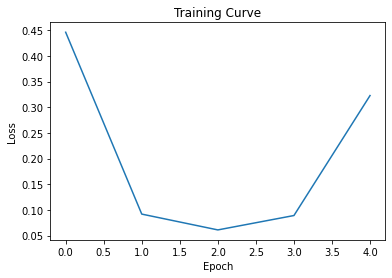

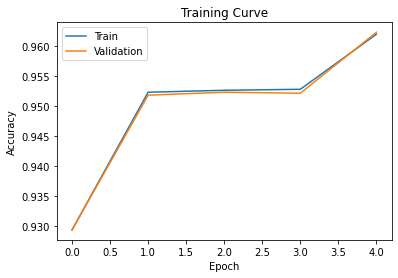

In [ ]:
model = GURU(len(text_field.vocab.itos), 150, 2)
train_guru(model, train_iter, val_iter, num_epochs=5, learning_rate=1e-3)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

We will alter:
- Learning rate
- Changing hidden unit
- Lowering number of epochs
- Changing batch size

Learning rate = 1e-5

Lesson: Doesn't learn the data or is too slow to do so

Epoch 1; Loss 0.624606; Train Acc 0.526980; Val Acc 0.526980
Epoch 2; Loss 0.799300; Train Acc 0.526980; Val Acc 0.526980
Epoch 3; Loss 0.631500; Train Acc 0.526980; Val Acc 0.526980
Epoch 4; Loss 0.791016; Train Acc 0.526980; Val Acc 0.526980
Epoch 5; Loss 0.601852; Train Acc 0.526980; Val Acc 0.526980


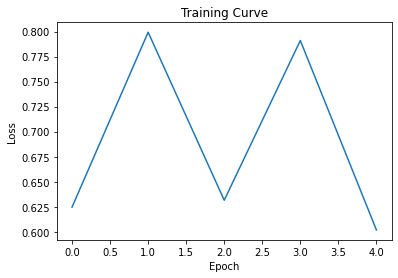

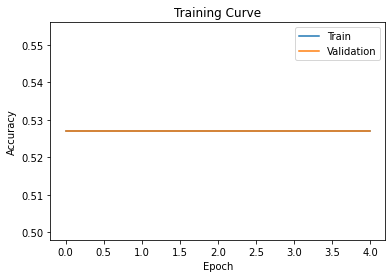

In [ ]:
# Learning rate = 1e-5 - Doesn't learn
model_lr_low = GURU(len(text_field.vocab.itos), 150, 2)
train_guru(model_lr_low, train_iter, val_iter, num_epochs=5, learning_rate=1e-5)

Learning rate = 1e-1

Lesson: Achieves a good first epoch accuracy but seems to struggle in converging further

Epoch 1; Loss 0.871254; Train Acc 0.945875; Val Acc 0.944891
Epoch 2; Loss 0.052637; Train Acc 0.963589; Val Acc 0.963917
Epoch 3; Loss 0.012958; Train Acc 0.950795; Val Acc 0.952108
Epoch 4; Loss 0.337041; Train Acc 0.964573; Val Acc 0.963589
Epoch 5; Loss 0.148175; Train Acc 0.969329; Val Acc 0.967689


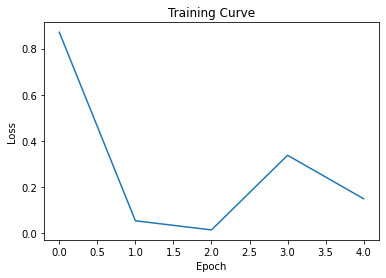

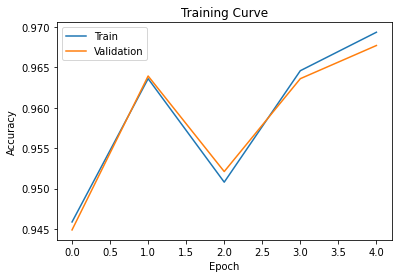

In [ ]:
# Learning rate = 1e-1 - Achieves a good first epoch accuracy but seems to struggle in converging further
model_lr_high = GURU(len(text_field.vocab.itos), 150, 2)
train_guru(model_lr_high, train_iter, val_iter, num_epochs=5, learning_rate=1e-1)

More hidden units are added

Lesson: It helps us learn faster too, but it might be just because of a higher learning rate. So we will try decreasing the number of hidden units

Epoch 1; Loss 0.274024; Train Acc 0.936526; Val Acc 0.936690
Epoch 2; Loss 0.068091; Train Acc 0.952764; Val Acc 0.952108
Epoch 3; Loss 0.012173; Train Acc 0.965229; Val Acc 0.964409
Epoch 4; Loss 0.303590; Train Acc 0.973266; Val Acc 0.973594
Epoch 5; Loss 0.040904; Train Acc 0.965721; Val Acc 0.966541


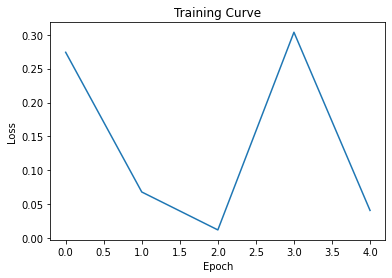

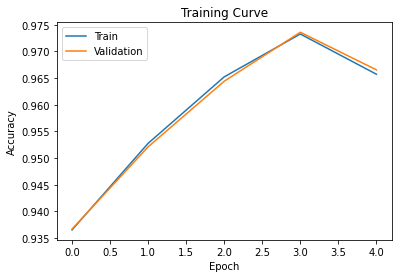

In [ ]:
# More hidden units
big_model = GURU(len(text_field.vocab.itos), 200, 2)
train_guru(big_model, train_iter, val_iter, num_epochs=5, learning_rate=1e-3)

Less hidden units: The model performance was very similar to previous experiment with higher number of hidden units.

Lesson: We observe that number of hidden units does not make that big of a difference

Epoch 1; Loss 0.112131; Train Acc 0.921601; Val Acc 0.920945
Epoch 2; Loss 0.320226; Train Acc 0.950467; Val Acc 0.949319
Epoch 3; Loss 0.034133; Train Acc 0.955716; Val Acc 0.956864
Epoch 4; Loss 0.885681; Train Acc 0.954568; Val Acc 0.954404
Epoch 5; Loss 0.160016; Train Acc 0.961456; Val Acc 0.961292


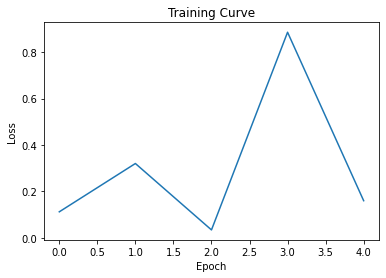

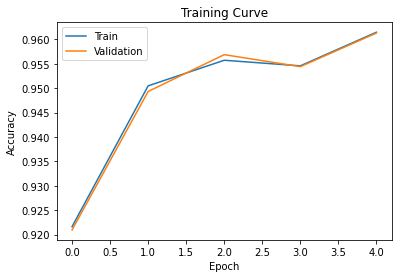

In [ ]:
# Less hidden units
small_model = GURU(len(text_field.vocab.itos), 100, 2)
train_guru(small_model, train_iter, val_iter, num_epochs=5, learning_rate=1e-3)

Epoch = 10

Lesson: More number of epochs definetly helped us to reach a higher train and validation accuracy!

Epoch 1; Loss 0.198448; Train Acc 0.936526; Val Acc 0.935870
Epoch 2; Loss 0.026090; Train Acc 0.953748; Val Acc 0.953092
Epoch 3; Loss 0.063039; Train Acc 0.962441; Val Acc 0.961128
Epoch 4; Loss 0.009400; Train Acc 0.965557; Val Acc 0.965229
Epoch 5; Loss 0.057929; Train Acc 0.972117; Val Acc 0.972117
Epoch 6; Loss 0.044658; Train Acc 0.972773; Val Acc 0.972445
Epoch 7; Loss 0.048001; Train Acc 0.981630; Val Acc 0.982614
Epoch 8; Loss 0.026755; Train Acc 0.985895; Val Acc 0.986059
Epoch 9; Loss 0.016324; Train Acc 0.983270; Val Acc 0.983927
Epoch 10; Loss 0.015428; Train Acc 0.994752; Val Acc 0.994916


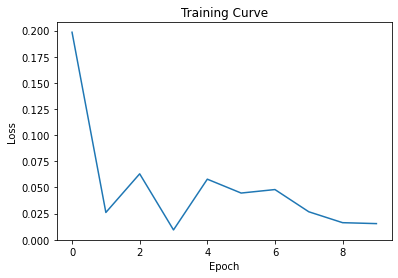

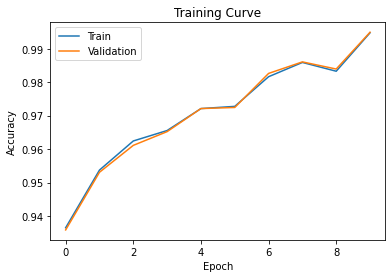

In [ ]:
# More epochs
model = GURU(len(text_field.vocab.itos), 150, 2)
train_guru(model, train_iter, val_iter, num_epochs=10, learning_rate=1e-3)

Batch size = 64

Lesson: The training curve had a huge dip in performance at epoch 2 and the final val accuracy is lower than the model with batch size = 32. Hence, increasing batch size does not help us

In [ ]:
train_iter = torchtext.legacy.data.BucketIterator(train,
                                           batch_size=64,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

val_iter = torchtext.legacy.data.BucketIterator(valid,
                                           batch_size=64,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

Epoch 1; Loss 0.110442; Train Acc 0.928653; Val Acc 0.928981
Epoch 2; Loss 0.419850; Train Acc 0.665737; Val Acc 0.665737
Epoch 3; Loss 0.714833; Train Acc 0.749057; Val Acc 0.749057
Epoch 4; Loss 0.236843; Train Acc 0.869280; Val Acc 0.869280
Epoch 5; Loss 0.127495; Train Acc 0.931770; Val Acc 0.931442


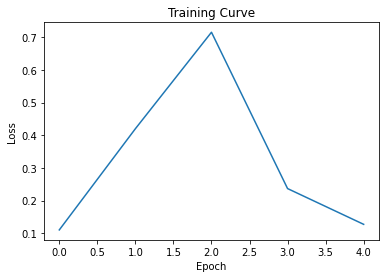

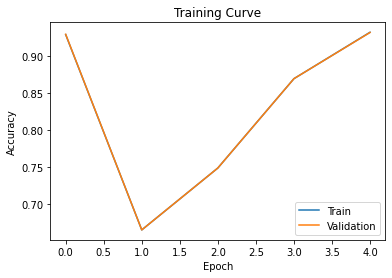

In [ ]:
model_64 = GURU(len(text_field.vocab.itos), 150, 2)
train_guru(model_64, train_iter, val_iter, num_epochs=5, learning_rate=1e-3)

Batch size = 16

Lesson: Batch size = 16 gives a minor accuracy gain over our base model with batch size 32.

In [ ]:
train_iter = torchtext.legacy.data.BucketIterator(train,
                                           batch_size=16,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

val_iter = torchtext.legacy.data.BucketIterator(valid,
                                           batch_size=16,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

Epoch 1; Loss 0.040450; Train Acc 0.951452; Val Acc 0.951124
Epoch 2; Loss 0.014490; Train Acc 0.958832; Val Acc 0.958340
Epoch 3; Loss 0.066004; Train Acc 0.968673; Val Acc 0.967525
Epoch 4; Loss 0.047996; Train Acc 0.976874; Val Acc 0.978022
Epoch 5; Loss 0.007523; Train Acc 0.981630; Val Acc 0.980810


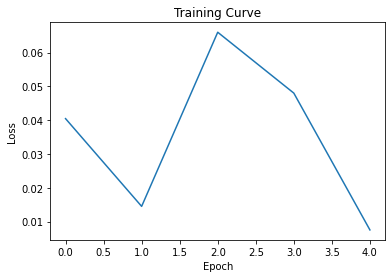

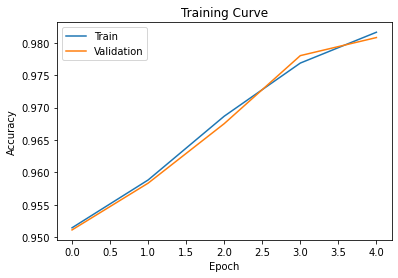

In [ ]:
model_16 = GURU(len(text_field.vocab.itos), 150, 2)
train_guru(model_16, train_iter, val_iter, num_epochs=5, learning_rate=1e-3)

From the experiments above we choose:
- Learning rate = 1e-3
- Hidden units = 150
- Epoch = 10
- Batch size = 16

Epoch 1; Loss 0.039686; Train Acc 0.961456; Val Acc 0.961292
Epoch 2; Loss 0.011357; Train Acc 0.964737; Val Acc 0.964409
Epoch 3; Loss 0.069452; Train Acc 0.977858; Val Acc 0.976874
Epoch 4; Loss 0.076722; Train Acc 0.974906; Val Acc 0.977202
Epoch 5; Loss 0.006192; Train Acc 0.990487; Val Acc 0.990815
Epoch 6; Loss 0.001352; Train Acc 0.989995; Val Acc 0.990651
Epoch 7; Loss 0.000121; Train Acc 0.998196; Val Acc 0.998196
Epoch 8; Loss 0.008194; Train Acc 0.996884; Val Acc 0.997048
Epoch 9; Loss 0.000845; Train Acc 0.999672; Val Acc 0.999836
Epoch 10; Loss 0.000564; Train Acc 1.000000; Val Acc 1.000000


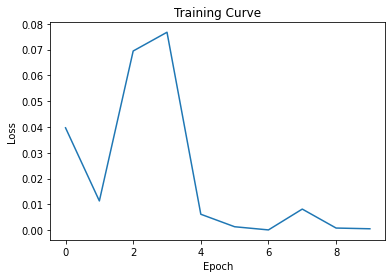

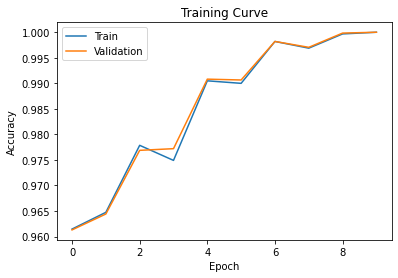

In [ ]:
final_model = GURU(len(text_field.vocab.itos), 150, 2)
train_guru(final_model, train_iter, val_iter, num_epochs=10, learning_rate=1e-3)

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [ ]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)

# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)

# Negative labels: No - spam
# Positive labels: Spam

In [ ]:
# false negative rate
1 - get_accuracy(final_model, valid_spam)

0.03706741020173854

In [ ]:
# false positive rate
1 - get_accuracy(final_model, valid_nospam)

0.03772347055929148

### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

ANS:

Imapct of false positive:
In our case negative labels refer to no-spam labels. So if no-spam messages were regarded as spam then we might some important and legitimate messages as the algorithm might block them

Impact of false negative:
In our case spam messages might be passed out as no-spam and this makes the user vulnerable to spam messages and can lead to huge losses if the consumer is not careful

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [ ]:
get_accuracy(final_model, test_iter)

0.9806462194521895

### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [ ]:
# Create a Dataset of only spam validation examples
test_spam = torchtext.legacy.data.Dataset(
    [e for e in test.examples if e.label == 1],
    test.fields)

# Create a Dataset of only non-spam validation examples
test_nospam = torchtext.legacy.data.Dataset(
    [e for e in test.examples if e.label == 0],
    test.fields)

# Negative labels: No - spam
# Positive labels: Spam

In [ ]:
# false negative rate
1 - get_accuracy(final_model, test_spam)

0.01886173527964574

In [ ]:
# false positive rate
1 - get_accuracy(final_model, test_nospam)

0.01804165983270456

### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [ ]:
msg = "machine learning is sooo cool!"
vocab_mapping = []
for i in range(len(msg)):
  if msg[i] in text_field.vocab.stoi.keys():
    vocab_mapping.append(text_field.vocab.stoi[msg[i]])
  else:
    vocab_mapping.append(0)

print(torch.LongTensor([vocab_mapping]))

tensor([[17,  6, 16, 14,  9,  7,  3,  2, 11,  3,  6,  8,  7,  9,  7, 22,  2,  9,
         10,  2, 10,  4,  4,  4,  2, 16,  4,  4, 11, 45]])


In [ ]:
m = nn.Softmax(dim=1)
out = model(torch.LongTensor([vocab_mapping]))
out = m(out)[0]
print(out)
if out[0] > 0.5:
  print("Prediction: No spam")
else:
  print("Prediction: Spam")

tensor([0.9453, 0.0547], grad_fn=<SelectBackward0>)
Prediction: No spam


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

ANS:

I have once worked with naive bayes for a similar task. It works as follows:

It uses the probability of words appearing in each category. In other words this is the probability of a word appearing given we know the category

This is a pure statistical method So there is no training loops as such. In this case, we just calculate the probability of each word based on our train dataset.

Then when we see a new example (test data) we get the probability of all classes using the following formula:

P(class) \* P(word 0 given the class) \* P(word 1 given the class) * ...

And so on for all the classes. At the end the class with the max probability is selected

---
# The end